# STEP 01. A & notA 구분

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import gc
import math
import random
import pickle
import pandas as pd
import numpy as np
import multiprocessing
from tqdm.auto import tqdm

from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, sampler

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN
from imblearn.under_sampling import RandomUnderSampler

import shap
import catboost
from catboost import Pool, cv

pd.set_option('display.max_columns', 500)

In [2]:
train = pd.read_csv("./data/train.csv").drop(columns=['father', 'mother', 'gender'])
train.drop_duplicates(subset=train.columns.tolist()[5:20], inplace=True, ignore_index=True)
test = pd.read_csv("./data/test.csv").drop(columns=['father', 'mother', 'gender'])

train.iloc[:, 1:-1] = train.iloc[:, 1:-1].astype('category')
test.iloc[:, 1:] = test.iloc[:, 1:].astype('category')

answer = np.zeros(len(test)) - 1

train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      248 non-null    object  
 1   trait   248 non-null    category
 2   SNP_01  248 non-null    category
 3   SNP_02  248 non-null    category
 4   SNP_03  248 non-null    category
 5   SNP_04  248 non-null    category
 6   SNP_05  248 non-null    category
 7   SNP_06  248 non-null    category
 8   SNP_07  248 non-null    category
 9   SNP_08  248 non-null    category
 10  SNP_09  248 non-null    category
 11  SNP_10  248 non-null    category
 12  SNP_11  248 non-null    category
 13  SNP_12  248 non-null    category
 14  SNP_13  248 non-null    category
 15  SNP_14  248 non-null    category
 16  SNP_15  248 non-null    category
 17  class   248 non-null    object  
dtypes: category(16), object(2)
memory usage: 9.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data colu

(None, None)

In [3]:
def catgbmc(inputX, inputY, validX, validY, params) :  
    var_categ = inputX.columns.tolist()
    model = CatBoostClassifier(
        cat_features=var_categ,
        **params,
        task_type='GPU',
        devices='0',
        )
  
    model.fit(
        inputX, inputY,
        eval_set=(inputX, inputY)
        );     

    pred = model.predict(validX)
    score = f1_score(validY, pred, average='macro')
    print(score)
    
    return model

In [4]:
def catcv(inputX, inputY, params, cv_count) :  
    
    var_categ = inputX.columns.tolist()
    
    cv_dataset = Pool(data=inputX,
                      label=inputY,
                      cat_features=var_categ)
    
    scores = cv(cv_dataset,
                params,
                fold_count=cv_count,
                stratified=True,
                plot=True)

In [5]:
params = {'iterations':30,
          'learning_rate':0.03,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [6]:
X, y = train.drop(columns=['id', 'class']), (train['class'].values == 'A').astype('int')
X_test = test.drop(columns=['id']).copy()

catcv(X, y, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1
bestIteration = 0

Training on fold [1/5]

bestTest = 1
bestIteration = 0

Training on fold [2/5]

bestTest = 1
bestIteration = 0

Training on fold [3/5]

bestTest = 1
bestIteration = 0

Training on fold [4/5]

bestTest = 1
bestIteration = 0



In [7]:
params = {'iterations':1,
          'learning_rate':0.3,
          'l2_leaf_reg' : 10,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

modelA = catgbmc(X, y, X, y, params)

1.0


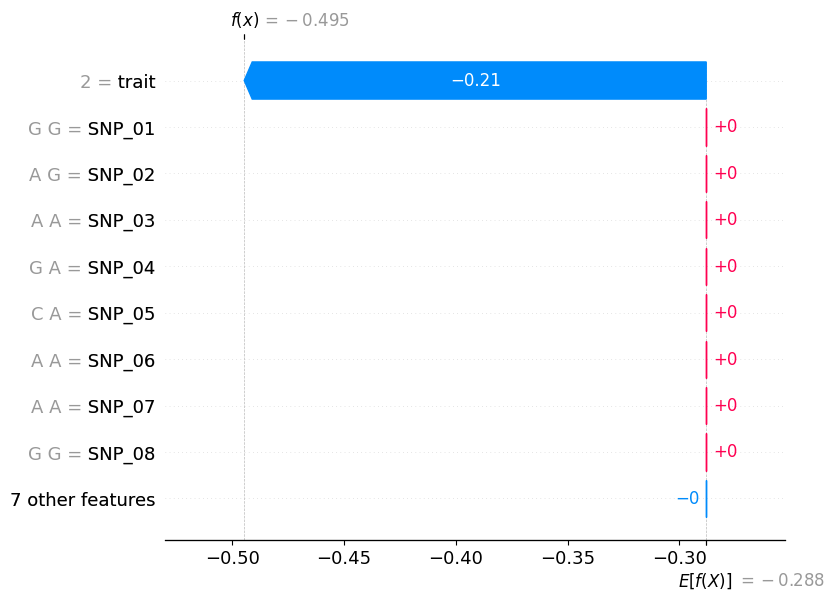

In [8]:
explainer = shap.Explainer(modelA)
shap_values = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [9]:
pd.DataFrame(data=modelA.get_feature_importance(), index=modelA.feature_names_, columns=['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
trait,100.0
SNP_01,0.0
SNP_02,0.0
SNP_03,0.0
SNP_04,0.0
SNP_05,0.0
SNP_06,0.0
SNP_07,0.0
SNP_08,0.0
SNP_09,0.0


In [10]:
predA = modelA.predict(X_test)
predA

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [11]:
answer += predA
answer

array([ 0., -1., -1., -1.,  0., -1., -1., -1.,  0.,  0., -1., -1., -1.,
        0., -1., -1.,  0., -1., -1., -1., -1., -1., -1.,  0., -1., -1.,
       -1.,  0.,  0., -1.,  0.,  0., -1., -1.,  0., -1., -1., -1., -1.,
       -1.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0., -1.,
        0., -1., -1., -1., -1.,  0., -1., -1.,  0., -1., -1., -1., -1.,
        0., -1.,  0.,  0., -1., -1., -1.,  0.,  0., -1., -1., -1., -1.,
       -1., -1., -1., -1.,  0., -1., -1., -1., -1., -1., -1.,  0., -1.,
       -1., -1., -1., -1., -1.,  0., -1.,  0., -1.,  0., -1., -1., -1.,
        0.,  0., -1., -1.,  0., -1., -1., -1., -1., -1., -1.,  0.,  0.,
       -1., -1., -1.,  0., -1., -1., -1., -1., -1., -1., -1.,  0., -1.,
        0.,  0., -1., -1., -1., -1.,  0.,  0., -1.,  0.,  0.,  0., -1.,
       -1., -1., -1.,  0., -1., -1.,  0.,  0., -1.,  0., -1., -1.,  0.,
        0., -1., -1.,  0., -1., -1., -1., -1.,  0.,  0., -1., -1., -1.,
        0., -1., -1., -1., -1., -1.])

# STEP 2. B & not B, C & notC

In [12]:
# A를 구분하는데에만 사용되는 trait 함수 제거

train2 = train.drop(columns=['trait'])
test2 = test.drop(columns=['trait'])

train2

,id,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,G G,A G,A A,G A,C A,A A,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,A G,A G,C A,A A,A A,A G,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,G G,G G,A A,G A,C C,G G,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,A A,G G,A A,G A,A A,G G,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,G G,G G,C C,A A,C C,A A,A A,A A,A A,G G,A A,A A,A G,A A,G A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,TRAIN_256,G G,G G,C A,G A,C C,A G,A A,G G,A A,G G,A G,G A,A A,A A,A A,B
244,TRAIN_257,A G,A G,A A,G A,C C,A G,A A,G A,A A,G G,A G,G A,A A,A A,A A,B
245,TRAIN_259,A G,G G,A A,G A,A A,A G,G G,G A,G A,A A,G G,G G,G G,C A,G G,A
246,TRAIN_260,A A,G G,A A,G A,A A,G G,G G,A A,G A,A G,A G,G A,G G,C A,G G,A


In [13]:
test2

,id,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,TEST_000,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A
1,TEST_001,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A
2,TEST_002,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G
3,TEST_003,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A
4,TEST_004,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,TEST_170,A G,G G,C C,A A,C A,A G,A A,G G,A A,G G,G G,A A,A A,A A,G A
171,TEST_171,G G,A A,A A,A A,C A,A G,A A,A A,A A,A G,A A,A A,A G,A A,G A
172,TEST_172,G G,A A,A A,A A,C A,A G,A A,A A,A A,G G,A G,A A,A G,A A,G G
173,TEST_173,A G,G G,C A,G A,C C,G G,A A,G A,A A,G G,A G,A A,A A,A A,A A


## 파생변수 생성

### 1) One-Hot Encoding

In [14]:
for i in tqdm(range(1, 15+1)) :
    target = str(i) if i >= 10 else "0"+str(i)
    cols = sorted(train2[f"SNP_{target}"].unique().tolist())
    train2[f"SNP_{target}"] = train2[f"SNP_{target}"].map(lambda x : -1 if x==cols[0] else (0 if x==cols[1] else 1))
    test2[f"SNP_{target}"] = test2[f"SNP_{target}"].map(lambda x : -1 if x==cols[0] else (0 if x==cols[1] else 1))

train2.info(), test2.info()

  0%|          | 0/15 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      248 non-null    object  
 1   SNP_01  248 non-null    category
 2   SNP_02  248 non-null    category
 3   SNP_03  248 non-null    category
 4   SNP_04  248 non-null    category
 5   SNP_05  248 non-null    category
 6   SNP_06  248 non-null    category
 7   SNP_07  248 non-null    category
 8   SNP_08  248 non-null    category
 9   SNP_09  248 non-null    category
 10  SNP_10  248 non-null    category
 11  SNP_11  248 non-null    category
 12  SNP_12  248 non-null    category
 13  SNP_13  248 non-null    category
 14  SNP_14  248 non-null    category
 15  SNP_15  248 non-null    category
 16  class   248 non-null    object  
dtypes: category(15), object(2)
memory usage: 9.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 16 columns):
 #   Column  N

(None, None)

### 2) Target Encoding

In [15]:
train2['class_B'] = train2['class'].map(lambda x : 1 if x=='B' else 0)
train2['class_C'] = train2['class'].map(lambda x : 1 if x=='C' else 0)

for i in range(1, 15+1) :
    target = str(i) if i >= 10 else "0"+str(i)
    target2 = train2.groupby(f'SNP_{target}')['class_B', 'class_C'].sum()
    target2['total'] = target2[['class_B', 'class_C']].sum(axis=1)
    for j in range(len(target2)) :
        if (target2['total'][j-1] < 3) : # 전체 표본이 너무 적은 경우 제외(확률 반반으로)
            target2['class_B'][j-1] = 1
            target2['class_C'][j-1] = 1
            
    value = target2['class_B'] / (target2['class_B']+target2['class_C'])    

    train2[f"SNP_{target}_ratio"] = train2[f"SNP_{target}"].map(lambda x : value[x]).astype(float)
    test2[f"SNP_{target}_ratio"] = test2[f"SNP_{target}"].map(lambda x : value[x]).astype(float)    

train2.drop(columns=['class_B', 'class_C'], inplace=True)
train2.info(), test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            248 non-null    object  
 1   SNP_01        248 non-null    category
 2   SNP_02        248 non-null    category
 3   SNP_03        248 non-null    category
 4   SNP_04        248 non-null    category
 5   SNP_05        248 non-null    category
 6   SNP_06        248 non-null    category
 7   SNP_07        248 non-null    category
 8   SNP_08        248 non-null    category
 9   SNP_09        248 non-null    category
 10  SNP_10        248 non-null    category
 11  SNP_11        248 non-null    category
 12  SNP_12        248 non-null    category
 13  SNP_13        248 non-null    category
 14  SNP_14        248 non-null    category
 15  SNP_15        248 non-null    category
 16  class         248 non-null    object  
 17  SNP_01_ratio  248 non-null    float64 
 18  SNP_02_rat

(None, None)

### 3) AutoEncoder

In [16]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super().__init__()
        self.encoding_dim = encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(30, 32),
            nn.GELU(),
            nn.Linear(32, 8),
            nn.GELU(),
            nn.Linear(8, encoding_dim),
            nn.GELU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 8),
            nn.GELU(),
            nn.Linear(8, 32),
            nn.GELU(),
            nn.Linear(32, 30)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x1, x2

def ae_train(model, data_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        epoch_loss = 0
        for x in data_loader:
            x = x[0].to(device)
            _, x_hat = model(x)
            loss = criterion(x_hat, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch}: loss = {epoch_loss / len(data_loader):.4f}')

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.Tensor(train2.drop(columns=['id', 'class']).to_numpy())

# Create a dataset and data loader
dataset = torch.utils.data.TensorDataset(X)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

# Initialize the model, criterion, and optimizer
encoding_dim = 4
model = Autoencoder(encoding_dim)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters())
epochs=3000

# Train the model
ae_train(model, data_loader, criterion, optimizer, device, epochs)

Epoch 0: loss = 0.4808
Epoch 1: loss = 0.3820
Epoch 2: loss = 0.2715
Epoch 3: loss = 0.2235
Epoch 4: loss = 0.1809
Epoch 5: loss = 0.1720
Epoch 6: loss = 0.1701
Epoch 7: loss = 0.1686
Epoch 8: loss = 0.1671
Epoch 9: loss = 0.1656
Epoch 10: loss = 0.1635
Epoch 11: loss = 0.1614
Epoch 12: loss = 0.1591
Epoch 13: loss = 0.1571
Epoch 14: loss = 0.1550
Epoch 15: loss = 0.1526
Epoch 16: loss = 0.1500
Epoch 17: loss = 0.1474
Epoch 18: loss = 0.1447
Epoch 19: loss = 0.1430
Epoch 20: loss = 0.1421
Epoch 21: loss = 0.1407
Epoch 22: loss = 0.1402
Epoch 23: loss = 0.1392
Epoch 24: loss = 0.1386
Epoch 25: loss = 0.1375
Epoch 26: loss = 0.1363
Epoch 27: loss = 0.1355
Epoch 28: loss = 0.1347
Epoch 29: loss = 0.1339
Epoch 30: loss = 0.1335
Epoch 31: loss = 0.1323
Epoch 32: loss = 0.1316
Epoch 33: loss = 0.1311
Epoch 34: loss = 0.1302
Epoch 35: loss = 0.1299
Epoch 36: loss = 0.1286
Epoch 37: loss = 0.1281
Epoch 38: loss = 0.1271
Epoch 39: loss = 0.1265
Epoch 40: loss = 0.1264
Epoch 41: loss = 0.1257
Ep

In [18]:
X1 = X.to(device)
X2 = torch.Tensor(test2.drop(columns='id').to_numpy()).to(device)

pred_train = model(X1)
pred_test = model(X2)

# reconstruction error
loss_train = []
loss_test = []

for i in range(len(X1)) :
    loss = criterion(pred_train[1][i], X1[i]).detach().cpu().numpy()
    loss_train.append(loss)
for j in range(len(X2)) :
    loss = criterion(pred_test[1][j], X2[j]).detach().cpu().numpy()
    loss_test.append(loss)

# encoding values
enco_train = pred_train[0].detach().cpu().numpy()
enco_test = pred_test[0].detach().cpu().numpy()

trainLoss = pd.DataFrame(data=loss_train, columns=['ae_loss'])
testLoss = pd.DataFrame(data=loss_test, columns=['ae_loss'])

ae_train = pd.DataFrame(data=enco_train, columns=['ae_'+str(x) for x in range(enco_train.shape[1])])
ae_test = pd.DataFrame(data=enco_test, columns=['ae_'+str(x) for x in range(enco_train.shape[1])])

train3 = pd.concat([train2, trainLoss, ae_train], axis=1)
test3 = pd.concat([test2, testLoss, ae_test], axis=1)

train3.info(), test3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            248 non-null    object  
 1   SNP_01        248 non-null    category
 2   SNP_02        248 non-null    category
 3   SNP_03        248 non-null    category
 4   SNP_04        248 non-null    category
 5   SNP_05        248 non-null    category
 6   SNP_06        248 non-null    category
 7   SNP_07        248 non-null    category
 8   SNP_08        248 non-null    category
 9   SNP_09        248 non-null    category
 10  SNP_10        248 non-null    category
 11  SNP_11        248 non-null    category
 12  SNP_12        248 non-null    category
 13  SNP_13        248 non-null    category
 14  SNP_14        248 non-null    category
 15  SNP_15        248 non-null    category
 16  class         248 non-null    object  
 17  SNP_01_ratio  248 non-null    float64 
 18  SNP_02_rat

(None, None)

### 4) Variational AutoEncoder

In [19]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU()
            )
        self.fc_mu = nn.Linear(input_dim//2, latent_dim)
        self.fc_logvar = nn.Linear(input_dim//2, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim//2),
            nn.ReLU(),
            nn.Linear(input_dim//2, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_fn(recon_x, x, mu, logvar):
    reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_loss

def vae_train(model, optimizer, train_loader, device):
    model.train()
    train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_fn(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        
        optimizer.step()
        
    return train_loss / len(train_loader.dataset)

def vae_test(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_fn(recon_batch, data, mu, logvar).item()
    return test_loss / len(test_loader.dataset)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.Tensor(train2.drop(columns=['id', 'class']).to_numpy())

input_dim = X.shape[1]
latent_dim = 4
batch_size = 64
num_epochs = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = X
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = X
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = VAE(input_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs):
    train_loss = vae_train(model, optimizer, train_loader, device)
    test_loss = vae_test(model, test_loader, device)
    print(f"Epoch {epoch}: Train loss = {train_loss}, Test loss = {test_loss}")

Epoch 0: Train loss = 15.442347126622353, Test loss = 15.00021485359438
Epoch 1: Train loss = 14.785410727224042, Test loss = 14.40384994014617
Epoch 2: Train loss = 14.196861020980343, Test loss = 13.800375907651839
Epoch 3: Train loss = 13.604722545992944, Test loss = 13.207104344521799
Epoch 4: Train loss = 12.953849546370968, Test loss = 12.519906566989038
Epoch 5: Train loss = 12.221239889821698, Test loss = 11.789624614100303
Epoch 6: Train loss = 11.564740827006679, Test loss = 11.07290304860761
Epoch 7: Train loss = 10.773663920740928, Test loss = 10.402209128102948
Epoch 8: Train loss = 10.258532124180947, Test loss = 9.878033545709425
Epoch 9: Train loss = 9.862776971632435, Test loss = 9.741180419921875
Epoch 10: Train loss = 9.695275337465349, Test loss = 9.534552543394026
Epoch 11: Train loss = 9.418471797820061, Test loss = 9.470329284667969
Epoch 12: Train loss = 9.253042528706212, Test loss = 9.224578119093373
Epoch 13: Train loss = 9.259721325289819, Test loss = 9.1591

In [21]:
X1 = X.to(device)
X2 = torch.Tensor(test2.drop(columns='id').to_numpy()).to(device)

pred_train = model(X1)
pred_test = model(X2)

# reconstruction error
loss_train = []
loss_test = []

for i in range(len(X1)) :
    loss = criterion(pred_train[0][i], X1[i]).detach().cpu().numpy()
    loss_train.append(loss)
for j in range(len(X2)) :
    loss = criterion(pred_test[0][j], X2[j]).detach().cpu().numpy()
    loss_test.append(loss)

# encoding values
enco_train = pred_train[1].detach().cpu().numpy()
enco_test = pred_test[1].detach().cpu().numpy()

trainLoss = pd.DataFrame(data=loss_train, columns=['vae_loss'])
testLoss = pd.DataFrame(data=loss_test, columns=['vae_loss'])

ae_train = pd.DataFrame(data=enco_train, columns=['vae_'+str(x) for x in range(enco_train.shape[1])])
ae_test = pd.DataFrame(data=enco_test, columns=['vae_'+str(x) for x in range(enco_train.shape[1])])

train4 = pd.concat([train3, trainLoss, ae_train], axis=1)
test4 = pd.concat([test3, testLoss, ae_test], axis=1)

train4.info(), test4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 42 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            248 non-null    object  
 1   SNP_01        248 non-null    category
 2   SNP_02        248 non-null    category
 3   SNP_03        248 non-null    category
 4   SNP_04        248 non-null    category
 5   SNP_05        248 non-null    category
 6   SNP_06        248 non-null    category
 7   SNP_07        248 non-null    category
 8   SNP_08        248 non-null    category
 9   SNP_09        248 non-null    category
 10  SNP_10        248 non-null    category
 11  SNP_11        248 non-null    category
 12  SNP_12        248 non-null    category
 13  SNP_13        248 non-null    category
 14  SNP_14        248 non-null    category
 15  SNP_15        248 non-null    category
 16  class         248 non-null    object  
 17  SNP_01_ratio  248 non-null    float64 
 18  SNP_02_rat

(None, None)

## 파생변수 생성 여부에 따른 성능 차이 확인

In [22]:
def catcv(inputX, inputY, params, cv_count) :  
    
    var_categ = inputX.columns.tolist()
    
    cv_dataset = Pool(data=inputX,
                      label=inputY,
                      cat_features=var_categ)
    
    scores = cv(cv_dataset,
                params,
                fold_count=cv_count,
                stratified=True,
                plot=True)
    
def catcv_v2(inputX, inputY, params, cv_count) :  
    
    var_categ = inputX.columns.tolist()[:15]
    
    cv_dataset = Pool(data=inputX,
                      label=inputY,
                      cat_features=var_categ)
    
    scores = cv(cv_dataset,
                params,
                fold_count=cv_count,
                stratified=True,
                plot=True)

In [23]:
params = {'iterations':300,
          'learning_rate':0.3,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [24]:
# B & notB 파생변수 없는 버전 성능 확인
X, y = train.drop(columns=['trait', 'id', 'class']), (train['class'].values == 'B').astype('int')
X_test = test.drop(columns=['trait', 'id']).copy()

catcv(X, y, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8888888889
bestIteration = 6

Training on fold [1/5]

bestTest = 0.9777777778
bestIteration = 9

Training on fold [2/5]

bestTest = 0.9565217391
bestIteration = 7

Training on fold [3/5]

bestTest = 0.9302325581
bestIteration = 17

Training on fold [4/5]

bestTest = 0.9090909091
bestIteration = 53



In [25]:
# B & notB 파생변수 있는 버전 성능 확인
X, y = train4.drop(columns=['id', 'class']), (train['class'].values == 'B').astype('int')
X_test = test4.drop(columns=['id']).copy()

catcv_v2(X, y, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9361702128
bestIteration = 3

Training on fold [1/5]

bestTest = 0.9361702128
bestIteration = 2

Training on fold [2/5]

bestTest = 0.9333333333
bestIteration = 1

Training on fold [3/5]

bestTest = 0.976744186
bestIteration = 108

Training on fold [4/5]

bestTest = 0.9777777778
bestIteration = 4



In [26]:
# C & notC 파생변수 없는 버전 성능 확인
X, y = train.drop(columns=['trait', 'id', 'class']), (train['class'].values == 'C').astype('int')
X_test = test.drop(columns=['trait', 'id']).copy()

catcv(X, y, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.875
bestIteration = 70

Training on fold [1/5]

bestTest = 0.9090909091
bestIteration = 87

Training on fold [2/5]

bestTest = 0.9285714286
bestIteration = 12

Training on fold [3/5]

bestTest = 0.8965517241
bestIteration = 76

Training on fold [4/5]

bestTest = 0.9677419355
bestIteration = 40



In [27]:
# C & notC 파생변수 있는 버전 성능 확인
X, y = train4.drop(columns=['id', 'class']), (train['class'].values == 'C').astype('int')
X_test = test4.drop(columns=['id']).copy()

catcv_v2(X, y, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9333333333
bestIteration = 3

Training on fold [1/5]

bestTest = 0.8387096774
bestIteration = 5

Training on fold [2/5]

bestTest = 0.8965517241
bestIteration = 0

Training on fold [3/5]

bestTest = 0.9032258065
bestIteration = 16

Training on fold [4/5]

bestTest = 1
bestIteration = 8



- 파생변수를 생성하는 게 평균적인 성능향상에 기여하는 것으로 보임
- 그렇다면 데이터 증강 / 감소에 따른 성능을 확인

In [28]:
# B & notB 파생변수 있는 버전 성능 확인
X, y = train4.drop(columns=['id', 'class']), (train['class'].values == 'B').astype('int')
X_test = test4.drop(columns=['id']).copy()

strategy1 = {0:50, 1:50}
strategy2 = {0:1000, 1:1000}

smote1 = RandomUnderSampler(sampling_strategy=strategy1)
smote2 = SMOTEN(sampling_strategy=strategy2, k_neighbors=20)

X1, y1 = smote1.fit_resample(X, y)
X2, y2 = smote2.fit_resample(X, y)

In [29]:
catcv_v2(X1, y1, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9090909091
bestIteration = 3

Training on fold [1/5]

bestTest = 1
bestIteration = 2

Training on fold [2/5]

bestTest = 0.9090909091
bestIteration = 0

Training on fold [3/5]

bestTest = 1
bestIteration = 1

Training on fold [4/5]

bestTest = 1
bestIteration = 0



In [30]:
catcv_v2(X2, y2, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9974937343
bestIteration = 3

Training on fold [1/5]

bestTest = 0.992481203
bestIteration = 1

Training on fold [2/5]

bestTest = 0.9950248756
bestIteration = 1

Training on fold [3/5]

bestTest = 0.9900497512
bestIteration = 3

Training on fold [4/5]

bestTest = 0.9900990099
bestIteration = 3



In [31]:
# C & notC 파생변수 있는 버전 성능 확인
X, y = train4.drop(columns=['id', 'class']), (train['class'].values == 'C').astype('int')
X_test = test4.drop(columns=['id']).copy()

strategy1 = {0:50, 1:50}
strategy2 = {0:1000, 1:1000}

smote1 = RandomUnderSampler(sampling_strategy=strategy1)
smote2 = SMOTEN(sampling_strategy=strategy2, k_neighbors=20)

X1, y1 = smote1.fit_resample(X, y)
X2, y2 = smote2.fit_resample(X, y)

In [32]:
catcv_v2(X1, y1, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8888888889
bestIteration = 1

Training on fold [1/5]

bestTest = 0.9473684211
bestIteration = 3

Training on fold [2/5]

bestTest = 0.9473684211
bestIteration = 4

Training on fold [3/5]

bestTest = 0.9523809524
bestIteration = 30

Training on fold [4/5]

bestTest = 0.9
bestIteration = 205



In [33]:
catcv_v2(X2, y2, params, cv_count=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9925558313
bestIteration = 11

Training on fold [1/5]

bestTest = 0.9925187032
bestIteration = 20

Training on fold [2/5]

bestTest = 0.9924433249
bestIteration = 5

Training on fold [3/5]

bestTest = 0.99
bestIteration = 15

Training on fold [4/5]

bestTest = 0.9898989899
bestIteration = 13



- 일반적으로 데이터 증강에 따른 성능 향상이 확인되므로, 어느 정도 수준으로 증강을 시켜야 최적인지 테스트

In [34]:
# B & notB 파생변수 있는 버전 성능 확인
X, y = train4.drop(columns=['id', 'class']), (train['class'].values == 'B').astype('int')
X_test = test4.drop(columns=['id']).copy()

strategy1 = {0:180, 1:180}
strategy2 = {0:200, 1:200}
strategy3 = {0:250, 1:250}
strategy4 = {0:300, 1:300}
strategy5 = {0:400, 1:400}

smote1 = SMOTEN(sampling_strategy=strategy1, k_neighbors=13)
smote2 = SMOTEN(sampling_strategy=strategy2, k_neighbors=13)
smote3 = SMOTEN(sampling_strategy=strategy3, k_neighbors=13)
smote4 = SMOTEN(sampling_strategy=strategy4, k_neighbors=13)
smote5 = SMOTEN(sampling_strategy=strategy5, k_neighbors=13)

X1, y1 = smote1.fit_resample(X, y)
X2, y2 = smote2.fit_resample(X, y)
X3, y3 = smote3.fit_resample(X, y)
X4, y4 = smote4.fit_resample(X, y)
X5, y5 = smote5.fit_resample(X, y)

In [35]:
def catgbmc_v2(inputX, inputY, validX, validY, params) :  
    var_categ = inputX.columns.tolist()[:15]
    model = CatBoostClassifier(
        cat_features=var_categ,
        **params,
        task_type='GPU',
        devices='0',
        )
  
    model.fit(
        inputX, inputY,
        eval_set=(inputX, inputY)
        );     

    pred = model.predict(validX)
    score = f1_score(validY, pred, average='macro')
    print(score)
    
    return model

In [36]:
params = {'iterations':30,
          'learning_rate':0.1,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [37]:
model1 = catgbmc_v2(X1, y1, X, y, params)
model2 = catgbmc_v2(X2, y2, X, y, params)
model3 = catgbmc_v2(X3, y3, X, y, params)
model4 = catgbmc_v2(X4, y4, X, y, params)
model5 = catgbmc_v2(X5, y5, X, y, params)

1.0
0.995919374742904
0.9918458604589991
0.983718487394958
0.9918458604589991


In [38]:
params = {'iterations':30,
          'learning_rate':0.1,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [39]:
modelB = catgbmc_v2(X1, y1, X, y, params)

1.0


In [40]:
pd.DataFrame(data=modelB.get_feature_importance(), index=modelB.feature_names_, columns=['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
vae_0,33.154511
ae_1,18.434870
ae_0,5.715733
SNP_04_ratio,4.691281
ae_loss,4.647749
SNP_15_ratio,3.856905
SNP_08_ratio,3.698044
ae_3,3.670152
vae_2,2.834987
SNP_03_ratio,2.597555


In [51]:
# C & notC 파생변수 있는 버전 성능 확인
X, y = train4.drop(columns=['id', 'class']), (train['class'].values == 'C').astype('int')
X_test = test4.drop(columns=['id']).copy()

strategy1 = {0:180, 1:180}
strategy2 = {0:200, 1:200}
strategy3 = {0:250, 1:250}
strategy4 = {0:300, 1:300}
strategy5 = {0:400, 1:400}

smote1 = SMOTEN(sampling_strategy=strategy1, k_neighbors=14, random_state=0)
smote2 = SMOTEN(sampling_strategy=strategy2, k_neighbors=14, random_state=0)
smote3 = SMOTEN(sampling_strategy=strategy3, k_neighbors=14, random_state=0)
smote4 = SMOTEN(sampling_strategy=strategy4, k_neighbors=14, random_state=0)
smote5 = SMOTEN(sampling_strategy=strategy5, k_neighbors=14, random_state=0)

X1, y1 = smote1.fit_resample(X, y)
X2, y2 = smote2.fit_resample(X, y)
X3, y3 = smote3.fit_resample(X, y)
X4, y4 = smote4.fit_resample(X, y)
X5, y5 = smote5.fit_resample(X, y)

In [52]:
params = {'iterations':50,
          'learning_rate':0.1,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [53]:
model1 = catgbmc_v2(X1, y1, X, y, params)
model2 = catgbmc_v2(X2, y2, X, y, params)
model3 = catgbmc_v2(X3, y3, X, y, params)
model4 = catgbmc_v2(X4, y4, X, y, params)
model5 = catgbmc_v2(X5, y5, X, y, params)

1.0
0.995274300196269
1.0
1.0
1.0


In [54]:
params = {'iterations':39,
          'learning_rate':0.1,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [55]:
modelC = catgbmc_v2(X1, y1, X, y, params)

1.0


In [56]:
pd.DataFrame(data=modelC.get_feature_importance(), index=modelC.feature_names_, columns=['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
ae_1,22.840309
SNP_04_ratio,20.615041
vae_0,16.829956
ae_3,12.589336
SNP_02_ratio,2.955156
vae_loss,2.703289
SNP_03_ratio,2.532646
SNP_15_ratio,2.377708
ae_loss,2.361447
SNP_14_ratio,2.140892


# STEP 3. B & C

In [57]:
train5 = train4[train4['class'] != 'A'].drop_duplicates().reset_index(drop=True)
train5['class'].value_counts()

B    111
C     77
Name: class, dtype: int64

In [70]:
# C & notC 파생변수 있는 버전 성능 확인
X, y = train4.drop(columns=['id', 'class']), (train['class'].values == 'C').astype('int')
X_test = test4.drop(columns=['id']).copy()

strategy1 = {0:180, 1:180}
strategy2 = {0:200, 1:200}
strategy3 = {0:250, 1:250}
strategy4 = {0:300, 1:300}
strategy5 = {0:400, 1:400}

smote1 = SMOTEN(sampling_strategy=strategy1, k_neighbors=18, random_state=2023)
smote2 = SMOTEN(sampling_strategy=strategy2, k_neighbors=18, random_state=2023)
smote3 = SMOTEN(sampling_strategy=strategy3, k_neighbors=18, random_state=2023)
smote4 = SMOTEN(sampling_strategy=strategy4, k_neighbors=18, random_state=2023)
smote5 = SMOTEN(sampling_strategy=strategy5, k_neighbors=18, random_state=2023)

X1, y1 = smote1.fit_resample(X, y)
X2, y2 = smote2.fit_resample(X, y)
X3, y3 = smote3.fit_resample(X, y)
X4, y4 = smote4.fit_resample(X, y)
X5, y5 = smote5.fit_resample(X, y)

In [71]:
params = {'iterations':30,
          'learning_rate':0.1,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [72]:
model1 = catgbmc_v2(X1, y1, X, y, params)
model2 = catgbmc_v2(X2, y2, X, y, params)
model3 = catgbmc_v2(X3, y3, X, y, params)
model4 = catgbmc_v2(X4, y4, X, y, params)
model5 = catgbmc_v2(X5, y5, X, y, params)

0.995274300196269
1.0
0.9953079178885631
1.0
0.9905825168983063


In [77]:
params = {'iterations':30,
          'learning_rate':0.1,
          'loss_function' : 'CrossEntropy',
          'eval_metric' : 'F1',
          'verbose':0,
          'random_seed':0}

In [78]:
modelBC = catgbmc_v2(X2, y2, X, y, params)

1.0


In [79]:
pd.DataFrame(data=modelBC.get_feature_importance(), index=modelBC.feature_names_, columns=['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
SNP_04_ratio,21.279700
ae_1,20.173120
ae_3,16.914906
vae_0,13.486792
vae_loss,3.278379
SNP_02_ratio,2.823752
SNP_03_ratio,2.438819
SNP_07_ratio,2.373284
SNP_15_ratio,2.138699
vae_1,2.130260


In [83]:
submit = pd.DataFrame()
submit['predA'] = answer
submit['predB'] = modelB.predict_proba(X_test)[:,1]
submit['predC'] = modelC.predict_proba(X_test)[:,1]
submit['predBC'] = modelBC.predict_proba(X_test)[:,1]
submit

,predA,predB,predC,predBC
0,0.0,0.009078,0.021135,0.014486
1,-1.0,0.991989,0.009470,0.012970
2,-1.0,0.020147,0.969969,0.926472
3,-1.0,0.862063,0.437261,0.146099
4,0.0,0.015514,0.018617,0.016361
...,...,...,...,...
170,-1.0,0.968726,0.044607,0.033402
171,-1.0,0.027359,0.984322,0.982888
172,-1.0,0.024762,0.978948,0.964606
173,-1.0,0.991529,0.015269,0.011823


In [85]:
submit[(submit.predA == 0) & ((submit.predB > 0.5) | (submit.predC > 0.5))]

,predA,predB,predC,predBC
8,0.0,0.011277,0.506809,0.53638


In [88]:
submit[(submit.predB >= 0.5) & (submit.predC >= 0.5)]

,predA,predB,predC,predBC


In [89]:
submit[(submit.predA == -1) & (submit.predB < 0.5) & (submit.predC < 0.5)]

,predA,predB,predC,predBC


In [90]:
submit[(submit.predBC > 0.5) & ((submit.predB >= 0.5) | (submit.predC <0.5))]

,predA,predB,predC,predBC
35,-1.0,0.614398,0.256156,0.513055
117,-1.0,0.587460,0.272301,0.516020


In [98]:
submit['answer1'] = submit.predA.map(lambda x : 'A' if x==0 else -1)
submit.loc[(submit.answer1 == -1)&(submit.predB>=0.5), 'answer1'] = 'B'
submit.loc[(submit.answer1 == -1)&(submit.predC>=0.5), 'answer1'] = 'C'

submit['answer2'] = submit.predA.map(lambda x : 'A' if x==0 else -1)
submit.loc[(submit.answer2 == -1)&(submit.predB>=0.5), 'answer2'] = 'B'
submit.loc[(submit.answer2 == -1)&(submit.predC>=0.5), 'answer2'] = 'C'
submit.loc[(submit.answer2 == -1)&(submit.predBC>0.5), 'answer2'] = 'C'

In [103]:
submit['answer3'] = submit.predA.map(lambda x : 'A' if x==0 else -1)
submit.loc[(submit.answer3 == -1)&(submit.predBC<0.5), 'answer3'] = 'B'
submit.loc[(submit.answer3 == -1)&(submit.predBC>=0.5), 'answer3'] = 'C'

In [99]:
submit.answer1.value_counts()

B    87
A    51
C    37
Name: answer1, dtype: int64

In [100]:
submit.answer2.value_counts()

B    87
A    51
C    37
Name: answer2, dtype: int64

In [101]:
df = pd.read_csv("submit_high1.csv")
df['class'] = submit['answer1']
df.to_csv("submit_last1.csv", index=False)
df

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,B
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [102]:
df = pd.read_csv("submit_high1.csv")
df['class'] = submit['answer2']
df.to_csv("submit_last2.csv", index=False)
df

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,B
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [104]:
df = pd.read_csv("submit_high1.csv")
df['class'] = submit['answer3']
df.to_csv("submit_last3.csv", index=False)
df['class'].value_counts()

B    86
A    51
C    38
Name: class, dtype: int64